In [1]:
# get the working directory of the notebook
!pwd

/home/woodbury/rajiv/action-diffusion-failure/demo


In [2]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm import tqdm

# env import
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os

In [3]:
#@markdown ### **Environment**
#@markdown Defines a PyMunk-based Push-T environment `PushTEnv`.
#@markdown And it's subclass `PushTImageEnv`.
#@markdown
#@markdown **Goal**: push the gray T-block into the green area.
#@markdown
#@markdown Adapted from [Implicit Behavior Cloning](https://implicitbc.github.io/)


positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::

    y
    ^
    |      . (3, 3)
    |
    |   . (2, 2)
    |
    +------ > x

When False::

    +------ > x
    |
    |   . (2, 2)
    |
    |      . (3, 3)
    v
    y

"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

class DrawOptions(pymunk.SpaceDebugDrawOptions):
    def __init__(self, surface: pygame.Surface) -> None:
        """Draw a pymunk.Space on a pygame.Surface object.

        Typical usage::

        >>> import pymunk
        >>> surface = pygame.Surface((10,10))
        >>> space = pymunk.Space()
        >>> options = pymunk.pygame_util.DrawOptions(surface)
        >>> space.debug_draw(options)

        You can control the color of a shape by setting shape.color to the color
        you want it drawn in::

        >>> c = pymunk.Circle(None, 10)
        >>> c.color = pygame.Color("pink")

        See pygame_util.demo.py for a full example

        Since pygame uses a coordiante system where y points down (in contrast
        to many other cases), you either have to make the physics simulation
        with Pymunk also behave in that way, or flip everything when you draw.

        The easiest is probably to just make the simulation behave the same
        way as Pygame does. In that way all coordinates used are in the same
        orientation and easy to reason about::

        >>> space = pymunk.Space()
        >>> space.gravity = (0, -1000)
        >>> body = pymunk.Body()
        >>> body.position = (0, 0) # will be positioned in the top left corner
        >>> space.debug_draw(options)

        To flip the drawing its possible to set the module property
        :py:data:`positive_y_is_up` to True. Then the pygame drawing will flip
        the simulation upside down before drawing::

        >>> positive_y_is_up = True
        >>> body = pymunk.Body()
        >>> body.position = (0, 0)
        >>> # Body will be position in bottom left corner

        :Parameters:
                surface : pygame.Surface
                    Surface that the objects will be drawn on
        """
        self.surface = surface
        super(DrawOptions, self).__init__()

    def draw_circle(
        self,
        pos: Vec2d,
        angle: float,
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p = to_pygame(pos, self.surface)

        pygame.draw.circle(self.surface, fill_color.as_int(), p, round(radius), 0)
        pygame.draw.circle(self.surface, light_color(fill_color).as_int(), p, round(radius-4), 0)

        circle_edge = pos + Vec2d(radius, 0).rotated(angle)
        p2 = to_pygame(circle_edge, self.surface)
        line_r = 2 if radius > 20 else 1
        # pygame.draw.lines(self.surface, outline_color.as_int(), False, [p, p2], line_r)

    def draw_segment(self, a: Vec2d, b: Vec2d, color: SpaceDebugColor) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        pygame.draw.aalines(self.surface, color.as_int(), False, [p1, p2])

    def draw_fat_segment(
        self,
        a: Tuple[float, float],
        b: Tuple[float, float],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        r = round(max(1, radius * 2))
        pygame.draw.lines(self.surface, fill_color.as_int(), False, [p1, p2], r)
        if r > 2:
            orthog = [abs(p2[1] - p1[1]), abs(p2[0] - p1[0])]
            if orthog[0] == 0 and orthog[1] == 0:
                return
            scale = radius / (orthog[0] * orthog[0] + orthog[1] * orthog[1]) ** 0.5
            orthog[0] = round(orthog[0] * scale)
            orthog[1] = round(orthog[1] * scale)
            points = [
                (p1[0] - orthog[0], p1[1] - orthog[1]),
                (p1[0] + orthog[0], p1[1] + orthog[1]),
                (p2[0] + orthog[0], p2[1] + orthog[1]),
                (p2[0] - orthog[0], p2[1] - orthog[1]),
            ]
            pygame.draw.polygon(self.surface, fill_color.as_int(), points)
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p1[0]), round(p1[1])),
                round(radius),
            )
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p2[0]), round(p2[1])),
                round(radius),
            )

    def draw_polygon(
        self,
        verts: Sequence[Tuple[float, float]],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        ps = [to_pygame(v, self.surface) for v in verts]
        ps += [ps[0]]

        radius = 2
        pygame.draw.polygon(self.surface, light_color(fill_color).as_int(), ps)

        if radius > 0:
            for i in range(len(verts)):
                a = verts[i]
                b = verts[(i + 1) % len(verts)]
                self.draw_fat_segment(a, b, radius, fill_color, fill_color)

    def draw_dot(
        self, size: float, pos: Tuple[float, float], color: SpaceDebugColor
    ) -> None:
        p = to_pygame(pos, self.surface)
        pygame.draw.circle(self.surface, color.as_int(), p, round(size), 0)


def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

# env
class PushTEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0., 1.)

    def __init__(self,
            legacy=False,
            block_cog=None, 
            damping=None,
            render_action=True,
            render_size=96,
            reset_to_state=None
        ):
        self._seed = None
        self.seed()
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        # Local controller params.
        self.k_p, self.k_v = 100, 20    # PD control.z
        self.control_hz = self.metadata['video.frames_per_second']
        # legcay set_state for data compatiblity
        self.legacy = legacy

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0], dtype=np.float64),
            high=np.array([ws,ws,ws,ws,np.pi*2], dtype=np.float64),
            shape=(5,),
            dtype=np.float64
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0,0], dtype=np.float64),
            high=np.array([ws,ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    def reset(self):
        seed = self._seed
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatiblity
        state = self.reset_to_state
        if state is None:
            rs = np.random.RandomState(seed=seed)
            state = np.array([
                rs.randint(50, 450), rs.randint(50, 450),
                rs.randint(100, 400), rs.randint(100, 400),
                rs.randn() * 2 * np.pi - np.pi
                ])
        self._set_state(state)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (Vec2d(0, 0) - self.agent.velocity)
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0, 1)
        done = coverage > self.success_threshold
        terminated = done
        truncated = done

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self, mode):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple('TeleopAgent', ['act'])
        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(Vec2d(*pygame.mouse.get_pos()), self.screen)
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act
        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position) \
            + tuple(self.block.position) \
            + (self.block.angle % (2 * np.pi),))
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here dosn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            'pos_agent': np.array(self.agent.position),
            'vel_agent': np.array(self.agent.velocity),
            'block_pose': np.array(list(self.block.position) + [self.block.angle]),
            'goal_pose': self.goal_pose,
            'n_contacts': n_contact_points_per_step}
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)

        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is aleady ticked during in step for "human"


        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / 512 * 96).astype(np.int32)
                marker_size = int(8/96*self.render_size)
                thickness = int(1/96*self.render_size)
                cv2.drawMarker(img, coord,
                    color=(255,0,0), markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size, thickness=thickness)
        return img


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0,25536)
        self._seed = seed
        self.np_random = np.random.default_rng(seed)

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatiblity with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2],
            rotation=self.goal_pose[2])
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2],
            rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(
            matrix=tf_img_obj.params @ tf_obj_new.params
        )
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0]) + list(tf_img_new.translation) \
                + [tf_img_new.rotation])
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2)
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        self.block = self.add_tee((256, 300), 0)
        self.goal_color = pygame.Color('LightGreen')
        self.goal_pose = np.array([256,256,np.pi/4])  # x, y, theta (in radians)

        # Add collision handeling
        self.collision_handeler = self.space.add_collision_handler(0, 0)
        self.collision_handeler.post_solve = self._handle_collision
        self.n_contact_points = 0

        self.max_score = 50 * 100
        self.success_threshold = 0.90    # 95% coverage.

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color('LightGray')    # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color('RoyalBlue')
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color('LightSlateGray')
        self.space.add(body, shape)
        return body

    def add_tee(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices1)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body


class PushTImageEnv(PushTEnv):
    metadata = {"render.modes": ["rgb_array"], "video.frames_per_second": 10}

    def __init__(self,
            legacy=False,
            block_cog=None,
            damping=None,
            render_size=96):
        super().__init__(
            legacy=legacy,
            block_cog=block_cog,
            damping=damping,
            render_size=render_size,
            render_action=False)
        ws = self.window_size
        self.observation_space = spaces.Dict({
            'image': spaces.Box(
                low=0,
                high=1,
                shape=(3,render_size,render_size),
                dtype=np.float32
            ),
            'agent_pos': spaces.Box(
                low=0,
                high=ws,
                shape=(2,),
                dtype=np.float32
            )
        })
        self.render_cache = None

    def _get_obs(self):
        img = super()._render_frame(mode='rgb_array')

        agent_pos = np.array(self.agent.position)
        img_obs = np.moveaxis(img.astype(np.float32) / 255, -1, 0)
        obs = {
            'image': img_obs,
            'agent_pos': agent_pos
        }

        # draw action
        if self.latest_action is not None:
            action = np.array(self.latest_action)
            coord = (action / 512 * 96).astype(np.int32)
            marker_size = int(8/96*self.render_size)
            thickness = int(1/96*self.render_size)
            cv2.drawMarker(img, coord,
                color=(255,0,0), markerType=cv2.MARKER_CROSS,
                markerSize=marker_size, thickness=thickness)
        self.render_cache = img

        return obs

    def render(self, mode):
        assert mode == 'rgb_array'

        if self.render_cache is None:
            self._get_obs()

        return self.render_cache

In [4]:
#@markdown ### **Env Demo**
#@markdown Standard Gym Env (0.21.0 API)

# 0. create env object
env = PushTImageEnv()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs, info = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, terminated, truncated, info = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("obs['image'].shape:", obs['image'].shape, "float32, [0,1]")
    print("obs['agent_pos'].shape:", obs['agent_pos'].shape, "float32, [0,512]")
    print("action.shape: ", action.shape, "float32, [0,512]")

obs['image'].shape: (3, 96, 96) float32, [0,1]
obs['agent_pos'].shape: (2,) float32, [0,512]
action.shape:  (2,) float32, [0,512]


In [5]:
#@markdown ### **Dataset**
#@markdown
#@markdown Defines `PushTImageDataset` and helper functions
#@markdown
#@markdown The dataset class
#@markdown - Load data ((image, agent_pos), action) from a zarr storage
#@markdown - Normalizes each dimension of agent_pos and action to [-1,1]
#@markdown - Returns
#@markdown  - All possible segments with length `pred_horizon`
#@markdown  - Pads the beginning and the end of each episode with repetition
#@markdown  - key `image`: shape (obs_hoirzon, 3, 96, 96)
#@markdown  - key `agent_pos`: shape (obs_hoirzon, 2)
#@markdown  - key `action`: shape (pred_horizon, 2)

def create_sample_indices(
        episode_ends:np.ndarray, sequence_length:int,
        pad_before: int=0, pad_after: int=0):
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

# normalize data
def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# dataset
class PushTImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_path: str,
                 pred_horizon: int,
                 obs_horizon: int,
                 action_horizon: int):

        # read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')

        # float32, [0,1], (N,96,96,3)
        train_image_data = dataset_root['data']['img'][:]
        train_image_data = np.moveaxis(train_image_data, -1,1)
        # (N,3,96,96)

        # (N, D)
        train_data = {
            # first two dims of state vector are agent (i.e. gripper) locations
            'agent_pos': dataset_root['data']['state'][:,:2],
            'action': dataset_root['data']['action'][:]
        }
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)

        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        # images are already normalized
        normalized_train_data['image'] = train_image_data

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get nomralized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        nsample['image'] = nsample['image'][:self.obs_horizon,:]
        nsample['agent_pos'] = nsample['agent_pos'][:self.obs_horizon,:]
        return nsample


In [6]:
#@markdown ### **Dataset Demo**

# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=4,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['image'].shape:", batch['image'].shape)
print("batch['agent_pos'].shape:", batch['agent_pos'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
batch['agent_pos'].shape: torch.Size([64, 2, 2])
batch['action'].shape torch.Size([64, 16, 2])


In [7]:
#@markdown ### **Network**
#@markdown
#@markdown Defines a 1D UNet architecture `ConditionalUnet1D`
#@markdown as the noies prediction network
#@markdown
#@markdown Components
#@markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
#@markdown - `Downsample1d` Strided convolution to reduce temporal resolution
#@markdown - `Upsample1d` Transposed convolution to increase temporal resolution
#@markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
#@markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
#@markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
#@markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


In [8]:
#@markdown ### **Vision Encoder**
#@markdown
#@markdown Defines helper functions:
#@markdown - `get_resnet` to initialize standard ResNet vision encoder
#@markdown - `replace_bn_with_gn` to replace all BatchNorm layers with GroupNorm

def get_resnet(name:str, weights=None, **kwargs) -> nn.Module:
    """
    name: resnet18, resnet34, resnet50
    weights: "IMAGENET1K_V1", None
    """
    # Use standard ResNet implementation from torchvision
    func = getattr(torchvision.models, name)
    resnet = func(weights=weights, **kwargs)

    # remove the final fully connected layer
    # for resnet18, the output dim should be 512
    resnet.fc = torch.nn.Identity()
    return resnet


def replace_submodules(
        root_module: nn.Module,
        predicate: Callable[[nn.Module], bool],
        func: Callable[[nn.Module], nn.Module]) -> nn.Module:
    """
    Replace all submodules selected by the predicate with
    the output of func.

    predicate: Return true if the module is to be replaced.
    func: Return new module to use.
    """
    if predicate(root_module):
        return func(root_module)

    bn_list = [k.split('.') for k, m
        in root_module.named_modules(remove_duplicate=True)
        if predicate(m)]
    for *parent, k in bn_list:
        parent_module = root_module
        if len(parent) > 0:
            parent_module = root_module.get_submodule('.'.join(parent))
        if isinstance(parent_module, nn.Sequential):
            src_module = parent_module[int(k)]
        else:
            src_module = getattr(parent_module, k)
        tgt_module = func(src_module)
        if isinstance(parent_module, nn.Sequential):
            parent_module[int(k)] = tgt_module
        else:
            setattr(parent_module, k, tgt_module)
    # verify that all modules are replaced
    bn_list = [k.split('.') for k, m
        in root_module.named_modules(remove_duplicate=True)
        if predicate(m)]
    assert len(bn_list) == 0
    return root_module

def replace_bn_with_gn(
    root_module: nn.Module,
    features_per_group: int=16) -> nn.Module:
    """
    Relace all BatchNorm layers with GroupNorm.
    """
    replace_submodules(
        root_module=root_module,
        predicate=lambda x: isinstance(x, nn.BatchNorm2d),
        func=lambda x: nn.GroupNorm(
            num_groups=x.num_features//features_per_group,
            num_channels=x.num_features)
    )
    return root_module


In [9]:
#@markdown ### **Network Demo**

# construct ResNet18 encoder
# if you have multiple camera views, use seperate encoder weights for each view.
vision_encoder = get_resnet('resnet18')

# IMPORTANT!
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
vision_encoder = replace_bn_with_gn(vision_encoder)

# ResNet18 has output dim of 512
vision_feature_dim = 512
# agent_pos is 2 dimensional
lowdim_obs_dim = 2
# observation feature has 514 dims in total per step
obs_dim = vision_feature_dim + lowdim_obs_dim
action_dim = 2

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# the final arch has 2 parts
nets = nn.ModuleDict({
    'vision_encoder': vision_encoder,
    'noise_pred_net': noise_pred_net
})

# demo
with torch.no_grad():
    # example inputs
    image = torch.zeros((1, obs_horizon,3,96,96))
    agent_pos = torch.zeros((1, obs_horizon, 2))
    # vision encoder
    image_features = nets['vision_encoder'](
        image.flatten(end_dim=1))
    # (2,512)
    image_features = image_features.reshape(*image.shape[:2],-1)
    # (1,2,512)
    obs = torch.cat([image_features, agent_pos],dim=-1)
    # (1,2,514)

    noised_action = torch.randn((1, pred_horizon, action_dim))
    diffusion_iter = torch.zeros((1,))

    # the noise prediction network
    # takes noisy action, diffusion iteration and observation as input
    # predicts the noise added to action
    noise = nets['noise_pred_net'](
        sample=noised_action,
        timestep=diffusion_iter,
        global_cond=obs.flatten(start_dim=1))

    # illustration of removing noise
    # the actual noise removal is performed by NoiseScheduler
    # and is dependent on the diffusion noise schedule
    denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = nets.to(device)

number of parameters: 7.994727e+07


In [ ]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about 2.5 hours. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights

num_epochs = 200

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=nets.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=nets.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nimage = nbatch['image'][:,:obs_horizon].to(device)
                nagent_pos = nbatch['agent_pos'][:,:obs_horizon].to(device)
                naction = nbatch['action'].to(device)
                B = nagent_pos.shape[0]

                # encoder vision features
                image_features = nets['vision_encoder'](
                    nimage.flatten(end_dim=1))
                image_features = image_features.reshape(
                    *nimage.shape[:2],-1)
                # (B,obs_horizon,D)

                # concatenate vision feature and low-dim obs
                obs_features = torch.cat([image_features, nagent_pos], dim=-1)
                obs_cond = obs_features.flatten(start_dim=1)
                # (B, obs_horizon * obs_dim)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(nets.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_nets = nets
ema.copy_to(ema_nets.parameters())

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 26/100 [07:03<20:04, 16.28s/it, loss=0.0292]


KeyboardInterrupt: 

In [12]:
save_path = 'ema_100ep_pretrained_paper.pth'
torch.save({
    'model_state_dict': ema_nets.state_dict()
}, save_path)

In [10]:

save_path = '../logs/train/default_long_run_5-10/checkpoint_ema_epoch_400.pth'
# reload from checkpoint
reload = True

if reload:
    ema_nets = nn.ModuleDict({
        'vision_encoder': vision_encoder,
        'noise_pred_net': noise_pred_net
    })

    checkpoint = torch.load(save_path, map_location='cuda')

    ema_nets.load_state_dict(checkpoint['model_state_dict'])

In [9]:
#@markdown ### **Loading Pretrained Checkpoint**
#@markdown Set `load_pretrained = True` to load pretrained weights.

load_pretrained = True
if load_pretrained:
  ckpt_path = "pusht_vision_100ep.ckpt"
  if not os.path.isfile(ckpt_path):
      id = "1XKpfNSlwYMGaF5CncoFaLKCDTWoLAHf1&confirm=t"
      gdown.download(id=id, output=ckpt_path, quiet=False)

  state_dict = torch.load(ckpt_path, map_location='cuda')
  ema_nets = nets
  ema_nets.load_state_dict(state_dict)
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")

Pretrained weights loaded.


In [ ]:
#@markdown ### **Inference**

# limit enviornment interaction to 200 steps before termination
max_steps = 300
env = PushTImageEnv()
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(100000)

# get first observation
obs, info = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon number of observations
        images = np.stack([x['image'] for x in obs_deque])
        agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

        # normalize observation
        nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
        # images are already normalized to [0,1]
        nimages = images

        # device transfer
        nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32)
        # (2,3,96,96)
        nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
        # (2,2)

        # infer action
        with torch.no_grad():
            # get image features
            image_features = ema_nets['vision_encoder'](nimages)
            # (2,512)

            # concat with low-dim observations
            obs_features = torch.cat([image_features, nagent_poses], dim=-1)

            # reshape observation to (B,obs_horizon*obs_dim)
            obs_cond = obs_features.unsqueeze(0).flatten(start_dim=1)

            # initialize action from Guassian noise
            noisy_action = torch.randn(
                (B, pred_horizon, action_dim), device=device)
            naction = noisy_action

            # init scheduler
            noise_scheduler.set_timesteps(num_diffusion_iters)

            for k in noise_scheduler.timesteps:
                # predict noise
                noise_pred = ema_nets['noise_pred_net'](
                    sample=naction,
                    timestep=k,
                    global_cond=obs_cond
                )

                # inverse diffusion step (remove noise)
                naction = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=naction
                ).prev_sample

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from IPython.display import Video
vwrite('vis.mp4', imgs)
Video('vis.mp4', embed=True, width=256, height=256)

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:  55%|█████▌    | 110/200 [00:08<00:06, 13.32it/s, reward=1]    

Score:  1.0


### Quick Experiment With Notebook Code

In [11]:
def rollout(env, ema_nets, noise_scheduler, stats, max_steps=300):
    # get first observation
    obs, info = env.reset()

    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)
    # save visualization and rewards
    imgs = [env.render(mode='rgb_array')]
    rewards = list()
    done = False
    step_idx = 0

    with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon number of observations
            images = np.stack([x['image'] for x in obs_deque])
            agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

            # normalize observation
            nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
            # images are already normalized to [0,1]
            nimages = images

            # device transfer
            nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32)
            # (2,3,96,96)
            nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
            # (2,2)

            # infer action
            with torch.no_grad():
                # get image features
                image_features = ema_nets['vision_encoder'](nimages)
                # (2,512)

                # concat with low-dim observations
                obs_features = torch.cat([image_features, nagent_poses], dim=-1)

                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = obs_features.unsqueeze(0).flatten(start_dim=1)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_nets['noise_pred_net'](
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            # (action_horizon, action_dim)

            # execute action_horizon number of steps
            # without replanning
            for i in range(len(action)):
                # stepping env
                obs, reward, done, _, info = env.step(action[i])
                # save observations
                obs_deque.append(obs)
                # and reward/vis
                rewards.append(reward)
                imgs.append(env.render(mode='rgb_array'))

                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx > max_steps:
                    done = True
                if done:
                    break

    # print out the maximum target coverage
    print('Score: ', max(rewards))

    return rewards


num_trials = 50
num_successes = 0

for i in range(num_trials):
    print("Running trial {}".format(i))
    seed = np.random.randint(201, 25536)
    env = PushTImageEnv()
    env.seed(seed)
    rewards = rollout(env, ema_nets, noise_scheduler, stats, max_steps=300)
    if max(rewards) > 0.99999:
        num_successes += 1

print("Done with {} trials".format(num_trials))
print("Success rate: {}%".format(num_successes/num_trials*100))

Running trial 0


Eval PushTImageEnv: 301it [00:23, 12.88it/s, reward=0.454]                          


Score:  0.4540223261587381
Running trial 1


Eval PushTImageEnv: 301it [00:22, 13.41it/s, reward=0]                               


Score:  0.022413820333749564
Running trial 2


Eval PushTImageEnv: 301it [00:22, 13.41it/s, reward=0]                         


Score:  0.0
Running trial 3


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.742]                         


Score:  0.7553802530775757
Running trial 4


Eval PushTImageEnv:  56%|█████▌    | 167/300 [00:12<00:09, 13.51it/s, reward=1]     


Score:  1.0
Running trial 5


Eval PushTImageEnv: 301it [00:22, 13.47it/s, reward=0]                         


Score:  0.0
Running trial 6


Eval PushTImageEnv:  29%|██▉       | 88/300 [00:06<00:15, 13.59it/s, reward=1]    


Score:  1.0
Running trial 7


Eval PushTImageEnv: 301it [00:22, 13.47it/s, reward=0]                         


Score:  0.0
Running trial 8


Eval PushTImageEnv: 301it [00:22, 13.34it/s, reward=0.331]                           


Score:  0.7322770073380235
Running trial 9


Eval PushTImageEnv:  47%|████▋     | 140/300 [00:10<00:12, 13.22it/s, reward=1]      


Score:  1.0
Running trial 10


Eval PushTImageEnv: 301it [00:22, 13.46it/s, reward=0.684]                            


Score:  0.7168943680079912
Running trial 11


Eval PushTImageEnv:  24%|██▎       | 71/300 [00:05<00:17, 13.41it/s, reward=1]      


Score:  1.0
Running trial 12


Eval PushTImageEnv: 301it [00:22, 13.34it/s, reward=0.611]                           


Score:  0.714861286372723
Running trial 13


Eval PushTImageEnv:  40%|████      | 120/300 [00:08<00:13, 13.59it/s, reward=1]     


Score:  1.0
Running trial 14


Eval PushTImageEnv:  93%|█████████▎| 280/300 [00:20<00:01, 13.58it/s, reward=1]       


Score:  1.0
Running trial 15


Eval PushTImageEnv: 301it [00:22, 13.46it/s, reward=0]                         


Score:  0.0
Running trial 16


Eval PushTImageEnv:  38%|███▊      | 114/300 [00:08<00:14, 12.93it/s, reward=1]      


Score:  1.0
Running trial 17


Eval PushTImageEnv: 301it [00:22, 13.43it/s, reward=0.851]                           


Score:  0.8523163118422985
Running trial 18


Eval PushTImageEnv: 301it [00:22, 13.37it/s, reward=0.753]                         


Score:  0.9792207107824931
Running trial 19


Eval PushTImageEnv:  62%|██████▏   | 187/300 [00:14<00:08, 13.17it/s, reward=1]    


Score:  1.0
Running trial 20


Eval PushTImageEnv:  39%|███▉      | 118/300 [00:08<00:13, 13.29it/s, reward=1]    


Score:  1.0
Running trial 21


Eval PushTImageEnv:  73%|███████▎  | 218/300 [00:16<00:06, 13.16it/s, reward=1]      


Score:  1.0
Running trial 22


Eval PushTImageEnv: 301it [00:22, 13.39it/s, reward=0.127]                           


Score:  0.1267059536606206
Running trial 23


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.58]                            


Score:  0.6435215399094952
Running trial 24


Eval PushTImageEnv:  44%|████▍     | 133/300 [00:10<00:12, 13.23it/s, reward=1]     


Score:  1.0
Running trial 25


Eval PushTImageEnv: 301it [00:22, 13.40it/s, reward=0]                         


Score:  0.0
Running trial 26


Eval PushTImageEnv:  59%|█████▉    | 177/300 [00:13<00:09, 13.03it/s, reward=1]     


Score:  1.0
Running trial 27


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.571]                          


Score:  0.9993620977671586
Running trial 28


Eval PushTImageEnv: 301it [00:22, 13.37it/s, reward=0.497]                         


Score:  0.7556188295262699
Running trial 29


Eval PushTImageEnv:  47%|████▋     | 142/300 [00:10<00:11, 13.33it/s, reward=1]     


Score:  1.0
Running trial 30


Eval PushTImageEnv: 301it [00:22, 13.39it/s, reward=0.613]                           


Score:  0.7510284768401803
Running trial 31


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.75]                           


Score:  0.7667673164364861
Running trial 32


Eval PushTImageEnv:  35%|███▍      | 104/300 [00:07<00:14, 13.50it/s, reward=1]    


Score:  1.0
Running trial 33


Eval PushTImageEnv:  24%|██▎       | 71/300 [00:05<00:17, 13.33it/s, reward=1]      


Score:  1.0
Running trial 34


Eval PushTImageEnv:  37%|███▋      | 110/300 [00:08<00:14, 13.28it/s, reward=1]    


Score:  1.0
Running trial 35


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.461]                         


Score:  0.7657120234868278
Running trial 36


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.772]                         


Score:  0.951916262691061
Running trial 37


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.407]                           


Score:  0.5808900927949716
Running trial 38


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.367]                          


Score:  0.6881571663936339
Running trial 39


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0.924]                          


Score:  0.9816652233219783
Running trial 40


Eval PushTImageEnv:  31%|███       | 92/300 [00:07<00:16, 12.97it/s, reward=1]      


Score:  1.0
Running trial 41


Eval PushTImageEnv: 301it [00:22, 13.36it/s, reward=0.66]                           


Score:  0.9951226322757105
Running trial 42


Eval PushTImageEnv: 301it [00:22, 13.39it/s, reward=0]                         


Score:  0.0
Running trial 43


Eval PushTImageEnv: 301it [00:22, 13.38it/s, reward=0]                         


Score:  0.0
Running trial 44


Eval PushTImageEnv:  26%|██▌       | 77/300 [00:05<00:17, 13.00it/s, reward=1]     


Score:  1.0
Running trial 45


Eval PushTImageEnv: 301it [00:22, 13.37it/s, reward=0.726]                           


Score:  0.7449982462952109
Running trial 46


Eval PushTImageEnv:  48%|████▊     | 143/300 [00:10<00:11, 13.40it/s, reward=1]    


Score:  1.0
Running trial 47


Eval PushTImageEnv:  53%|█████▎    | 159/300 [00:11<00:10, 13.41it/s, reward=1]    


Score:  1.0
Running trial 48


Eval PushTImageEnv: 301it [00:22, 13.31it/s, reward=0]                         


Score:  0.0
Running trial 49


Eval PushTImageEnv:  65%|██████▍   | 194/300 [00:14<00:08, 13.10it/s, reward=1]     

Score:  1.0
Done with 50 trials
Success rate: 42.0%


In [ ]:
ema_nets = nn.ModuleDict({
        'vision_encoder': vision_encoder,
        'noise_pred_net': noise_pred_net
    })

checkpoint = torch.load(save_path, map_location='cuda')

ema_nets.load_state_dict(checkpoint['model_state_dict'])

num_trials = 20
num_successes = 0

for i in range(num_trials):
    print("Running trial {}".format(i))
    seed = np.random.randint(201, 25536)
    env = PushTImageEnv()
    env.seed(seed)
    rewards = rollout(env, ema_nets, noise_scheduler, stats, max_steps=300)
    if max(rewards) > 0.99:
        num_successes += 1

print("Done with {} trials".format(num_trials))
print("Success rate: {}%".format(num_successes/num_trials*100))

Running trial 0


Eval PushTImageEnv: 301it [00:22, 13.49it/s, reward=0.181]                            


Score:  0.18115635112364173
Running trial 1


Eval PushTImageEnv: 301it [00:22, 13.48it/s, reward=0]                         


Score:  0.0
Running trial 2


Eval PushTImageEnv:  39%|███▉      | 117/300 [00:08<00:13, 13.28it/s, reward=1]     


Score:  1.0
Running trial 3


Eval PushTImageEnv:  28%|██▊       | 84/300 [00:06<00:16, 13.01it/s, reward=1]       


Score:  1.0
Running trial 4


Eval PushTImageEnv:  66%|██████▌   | 198/300 [00:14<00:07, 13.45it/s, reward=1]    


Score:  1.0
Running trial 5


Eval PushTImageEnv: 301it [00:22, 13.46it/s, reward=0]                         


Score:  0.0
Running trial 6


Eval PushTImageEnv: 301it [00:22, 13.44it/s, reward=0.698]                           


Score:  0.6982718462180932
Running trial 7


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.0204]                          


Score:  0.02035116535189308
Running trial 8


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.673]                           


Score:  0.6790917914437211
Running trial 9


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.352]                         


Score:  0.6946783415602965
Running trial 10


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.956]                            


Score:  0.9564386367828666
Running trial 11


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.29]                          


Score:  0.7107728946307466
Running trial 12


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.95]                            


Score:  0.9734285980334141
Running trial 13


Eval PushTImageEnv:  76%|███████▋  | 229/300 [00:17<00:05, 13.41it/s, reward=1]     


Score:  1.0
Running trial 14


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.918]                           


Score:  0.9817548205057358
Running trial 15


Eval PushTImageEnv:  30%|███       | 91/300 [00:07<00:16, 12.89it/s, reward=1]    


Score:  1.0
Running trial 16


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.388]                           


Score:  0.99905161724666
Running trial 17


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0]                         


Score:  0.0
Running trial 18


Eval PushTImageEnv:  83%|████████▎ | 248/300 [00:18<00:03, 13.58it/s, reward=1]     


Score:  1.0
Running trial 19


Eval PushTImageEnv: 301it [00:22, 13.45it/s, reward=0.15]                            

Score:  0.6646536888545769
Done with 20 trials
Success rate: 35.0%


## Push-T Domain Randomization

In [35]:
env = PushTImageEnv()
env.seed(350)
# get first observation
obs, info = env.reset()

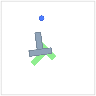

In [18]:
from PIL import Image

def render_im(image):
    img = (np.clip(image, 0, 1) * 255).astype(np.uint8)
    img = img.transpose(1,2,0)
    return Image.fromarray(img, mode='RGB')

render_im(obs['image'])

In [12]:
class PushTEnvGen(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0.0, 1.0)

    def __init__(
        self,
        seed=0,
        legacy=False,
        block_cog=None,
        damping=None,
        render_action=True,
        render_size=96,
        reset_to_state=None,
        max_episode_length=300,
        randomize_rotation=False,
        scale_low=1.0,
        scale_high=1.0,
        scale_aspect_limit=100.0,
        uniform_scaling=False,
        randomize_position=False,
        rand_pos_scale=0.0,
        term_on_success=True,
    ):
        print(f"Creating PushT Env with seed {seed}.")
        self.rng = np.random.RandomState(seed=seed)
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        self.max_episode_length = max_episode_length
        # Local controller params.
        self.k_p, self.k_v = 100, 20  # PD control.z
        self.control_hz = self.metadata["video.frames_per_second"]
        # legcay set_state for data compatibility
        self.legacy = legacy

        self.randomize_rotation = randomize_rotation
        self.scale_low, self.scale_high = scale_low, scale_high
        self.scale_aspect_limit = scale_aspect_limit
        self.uniform_scaling = uniform_scaling
        self.randomize_position = randomize_position
        self.rand_pos_scale = rand_pos_scale

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0], dtype=np.float64),
            high=np.array([ws, ws, ws, ws, np.pi * 2, np.pi * 2], dtype=np.float64),
            shape=(6,),
            dtype=np.float64,
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float64),
            high=np.array([ws, ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64,
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action
        self.term_on_success = term_on_success

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    @property
    def name(self):
        return "pusht"

    def reset(self):
        self._t = 0
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatibility
        state = self.reset_to_state
        if state is None:
            rs = self.rng
            state = np.array(
                [
                    rs.randint(50, 450),
                    rs.randint(50, 450),
                    rs.randint(100, 400),
                    rs.randint(100, 400),
                    rs.randn() * 2 * np.pi - np.pi,
                ]
            )
        self._set_state(state)

        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action, dummy_reward=False):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if (self.term_on_success and self.compute_reward() == 1.0) or (
            self._t + 1
        ) >= self.max_episode_length:
            # do not take action if done
            action = None
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (
                    Vec2d(0, 0) - self.agent.velocity
                )
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        reward = self.compute_reward()
        done = (self.term_on_success and reward == 1.0) or (
            self._t + 1
        ) >= self.max_episode_length
        observation = self._get_obs()
        info = self._get_info()
        self._t += 1

        return observation, reward if not dummy_reward else 0.0, done, done, info

    def compute_reward(self):
        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0.0, 1.0)
        return reward

    def render(self, mode):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple("TeleopAgent", ["act"])

        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(
                Vec2d(*pygame.mouse.get_pos()), self.screen
            )
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act

        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position)
            + tuple(self.block.position)
            + (self.block.angle % (2 * np.pi), self.goal_pose[-1])
        )
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here doesn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            "pos_agent": np.array(self.agent.position),
            "vel_agent": np.array(self.agent.velocity),
            "block_pose": np.array(list(self.block.position) + [self.block.angle]),
            "goal_pose": self.goal_pose,
            "n_contacts": n_contact_points_per_step,
        }
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [
                pymunk.pygame_util.to_pygame(
                    goal_body.local_to_world(v), draw_options.surface
                )
                for v in shape.get_vertices()
            ]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)
        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is already ticked during in step for "human"

        img = np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / 512 * self.render_size).astype(np.int32)
                marker_size = int(8 / 96 * self.render_size)
                thickness = int(1 / 96 * self.render_size)
                cv2.drawMarker(
                    img,
                    coord,
                    color=(255, 0, 0),
                    markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size,
                    thickness=thickness,
                )
        return img

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatibility with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2], rotation=self.goal_pose[2]
        )
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2], rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(matrix=tf_img_obj.params @ tf_obj_new.params)
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0])
            + list(tf_img_new.translation)
            + [tf_img_new.rotation]
        )
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2),
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        if self.scale_low == self.scale_high:
            self._length = 4
            self._scale = np.array([30.0, 30.0]) * self.scale_low
        else:
            scale_low, scale_high = self.scale_low, self.scale_high
            if self.uniform_scaling:
                scale = self.rng.rand() * (scale_high - scale_low) + scale_low
                scale = np.array([scale, scale])
            else:
                scale = self._sample_scale(
                    scale_low, scale_high, 2, aspect_limit=self.scale_aspect_limit
                )
            scale *= 30
            self._scale = scale
            self._length = 4 * (scale[0] / scale[1])
        self.block = self.add_tee(
            (256, 300), 0, length=self._length, scale=self._scale[1]
        )
        self.goal_color = pygame.Color("LightGreen")
        if not self.randomize_rotation:
            self.goal_pose = np.array([256, 256, np.pi / 4])  # x, y, theta (in radians)
        else:
            self.goal_pose = np.array([256, 256, np.pi * 2 * self.rng.rand()])
        if self.randomize_position:
            self.goal_pose[:2] += self.rng.randn(2) * self.rand_pos_scale

        # Add collision handling
        self.collision_handeler = self.space.add_collision_handler(0, 0)
        self.collision_handeler.post_solve = self._handle_collision
        self.n_contact_points = 0

        self.max_score = 50 * 100
        self.success_threshold = 0.90  # 95% coverage.

    def _sample_scale(self, low, high, size, aspect_limit=None):
        while True:
            scale = self.rng.rand(size) * (high - low) + low
            if aspect_limit is None or scale.max() / scale.min() < aspect_limit:
                break
        return scale

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color(
            "LightGray"
        )  # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color("RoyalBlue")
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color("LightSlateGray")
        self.space.add(body, shape)
        return body

    def add_tee(
        self,
        position,
        angle,
        length=4,
        scale=30,
        color="LightSlateGray",
        mask=pymunk.ShapeFilter.ALL_MASKS(),
    ):
        mass = 1
        vertices1 = [
            (-length * scale / 2, scale),
            (length * scale / 2, scale),
            (length * scale / 2, 0),
            (-length * scale / 2, 0),
        ]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [
            (-scale / 2, scale),
            (-scale / 2, length * scale),
            (scale / 2, length * scale),
            (scale / 2, scale),
        ]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices1)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (
            shape1.center_of_gravity + shape2.center_of_gravity
        ) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body

class PushTImageEnvGen(PushTEnvGen):
    metadata = {"render.modes": ["rgb_array"], "video.frames_per_second": 10}

    def __init__(self,
                 seed=0,
                 legacy=False,
                 block_cog=None,
                 damping=None,
                 render_size=96,
                 reset_to_state=None,
                 max_episode_length=300,
                 randomize_rotation=False,
                 scale_low=1.0,
                 scale_high=1.0,
                 scale_aspect_limit=100.0,
                 uniform_scaling=False,
                 randomize_position=False,
                 rand_pos_scale=0.0,
                 term_on_success=True):
        # disable the base action‐marker (we’ll draw it ourselves on the image)
        super().__init__(
            seed=seed,
            legacy=legacy,
            block_cog=block_cog,
            damping=damping,
            render_action=False,
            render_size=render_size,
            reset_to_state=reset_to_state,
            max_episode_length=max_episode_length,
            randomize_rotation=randomize_rotation,
            scale_low=scale_low,
            scale_high=scale_high,
            scale_aspect_limit=scale_aspect_limit,
            uniform_scaling=uniform_scaling,
            randomize_position=randomize_position,
            rand_pos_scale=rand_pos_scale,
            term_on_success=term_on_success
        )

        ws = self.window_size
        self.observation_space = spaces.Dict({
            "image": spaces.Box(
                low=0.0,
                high=1.0,
                shape=(3, render_size, render_size),
                dtype=np.float32
            ),
            "agent_pos": spaces.Box(
                low=0.0,
                high=ws,
                shape=(2,),
                dtype=np.float32
            )
        })

        # cache last rendered frame
        self.render_cache = None

    def _get_obs(self):
        # render raw RGB image
        img = super()._render_frame(mode="rgb_array")

        agent_pos = np.array(self.agent.position)
        img_obs = np.moveaxis(img.astype(np.float32) / 255, -1, 0)
        obs = {
            'image': img_obs,
            'agent_pos': agent_pos
        }
        # optionally overlay the action marker
        if self.latest_action is not None:
            coord = (np.array(self.latest_action) / self.window_size * self.render_size).astype(int)
            marker_size = int(8/96 * self.render_size)
            thickness = int(1/96 * self.render_size)
            cv2.drawMarker(
                img, tuple(coord),
                color=(255, 0, 0),
                markerType=cv2.MARKER_CROSS,
                markerSize=marker_size,
                thickness=thickness
            )
        self.render_cache = img

        assert self.render_cache is not None

        return obs

    def render(self, mode="rgb_array"):
        assert mode == "rgb_array"
        if self.render_cache is None:
            # if nobody’s called _get_obs() yet
            self._get_obs()
        return self.render_cache

In [17]:
env = PushTImageEnvGen(seed=100000,
                 legacy=False,
                 block_cog=None,
                 damping=None,
                 render_size=96,
                 reset_to_state=None,
                 max_episode_length=300,
                 randomize_rotation=False,
                 scale_low=1.0,
                 scale_high=1.0,
                 scale_aspect_limit=100.0,
                 uniform_scaling=False,
                 randomize_position=False,
                 rand_pos_scale=0.0,
                 term_on_success=True
                 )

obs, info = env.reset()

Creating PushT Env with seed 100000.


In [50]:
res = env.render(mode='rgb_array')

### Example Rollout with General Image Environment

In [22]:
ema_nets = nn.ModuleDict({
        'vision_encoder': vision_encoder,
        'noise_pred_net': noise_pred_net
    })

checkpoint = torch.load("ema_100ep_pretrained_paper.pth", map_location='cuda')

ema_nets.load_state_dict(checkpoint['model_state_dict'])

num_trials = 20
num_successes = 0

for i in range(num_trials):
    print("Running trial {}".format(i))
    seed = np.random.randint(201, 25536)
    env = PushTImageEnvGen(seed=seed)
    rewards = rollout(env, ema_nets, noise_scheduler, stats, max_steps=300)
    if max(rewards) > 0.99:
        num_successes += 1

print("Done with {} trials".format(num_trials))
print("Success rate: {}%".format(num_successes/num_trials*100))

Running trial 0
Creating PushT Env with seed 5695.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.39it/s, reward=0]


Score:  0.0
Running trial 1
Creating PushT Env with seed 6002.


Eval PushTImageEnv:  94%|█████████▎| 281/300 [00:21<00:01, 13.22it/s, reward=1]    


Score:  1.0
Running trial 2
Creating PushT Env with seed 14300.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.34it/s, reward=0.794]


Score:  0.9845342146134474
Running trial 3
Creating PushT Env with seed 15128.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.33it/s, reward=0.655]


Score:  0.7040764838381933
Running trial 4
Creating PushT Env with seed 6292.


Eval PushTImageEnv:  34%|███▍      | 102/300 [00:07<00:14, 13.27it/s, reward=1]     


Score:  1.0
Running trial 5
Creating PushT Env with seed 16166.


Eval PushTImageEnv:  84%|████████▍ | 252/300 [00:18<00:03, 13.31it/s, reward=1]      


Score:  1.0
Running trial 6
Creating PushT Env with seed 22014.


Eval PushTImageEnv:  70%|███████   | 210/300 [00:15<00:06, 13.15it/s, reward=1]    


Score:  1.0
Running trial 7
Creating PushT Env with seed 3282.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.35it/s, reward=0.671]  


Score:  0.6711708544499433
Running trial 8
Creating PushT Env with seed 13876.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.38it/s, reward=0.0818] 


Score:  0.5227994679089802
Running trial 9
Creating PushT Env with seed 21200.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.43it/s, reward=0.843] 


Score:  0.9583671330028058
Running trial 10
Creating PushT Env with seed 17034.


Eval PushTImageEnv:  96%|█████████▌| 287/300 [00:21<00:00, 13.57it/s, reward=1]      


Score:  1.0
Running trial 11
Creating PushT Env with seed 3553.


Eval PushTImageEnv:  55%|█████▍    | 164/300 [00:12<00:10, 13.30it/s, reward=1]     


Score:  1.0
Running trial 12
Creating PushT Env with seed 21529.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.44it/s, reward=0.333]  


Score:  0.7028519062421393
Running trial 13
Creating PushT Env with seed 21237.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.43it/s, reward=0.508] 


Score:  0.9939625575044712
Running trial 14
Creating PushT Env with seed 2198.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.47it/s, reward=0]


Score:  0.0
Running trial 15
Creating PushT Env with seed 4089.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.43it/s, reward=0.357]


Score:  0.7080589652952579
Running trial 16
Creating PushT Env with seed 1777.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.43it/s, reward=0.919]


Score:  0.9981723423385026
Running trial 17
Creating PushT Env with seed 1086.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.44it/s, reward=0.882] 


Score:  0.9886571971314005
Running trial 18
Creating PushT Env with seed 21903.


Eval PushTImageEnv:  43%|████▎     | 130/300 [00:09<00:13, 13.04it/s, reward=1]     


Score:  1.0
Running trial 19
Creating PushT Env with seed 1729.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.44it/s, reward=0.967]

Score:  0.9976370291863218
Done with 20 trials
Success rate: 50.0%


In [23]:
ema_nets = nn.ModuleDict({
        'vision_encoder': vision_encoder,
        'noise_pred_net': noise_pred_net
    })

checkpoint = torch.load("ema_100ep.pt", map_location='cuda')

ema_nets.load_state_dict(checkpoint['model_state_dict'])

num_trials = 20
num_successes = 0

for i in range(num_trials):
    print("Running trial {}".format(i))
    seed = np.random.randint(201, 25536)
    env = PushTImageEnvGen(seed=seed)
    rewards = rollout(env, ema_nets, noise_scheduler, stats, max_steps=300)
    if max(rewards) > 0.99:
        num_successes += 1

print("Done with {} trials".format(num_trials))
print("Success rate: {}%".format(num_successes/num_trials*100))

Running trial 0
Creating PushT Env with seed 25234.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.50it/s, reward=0]


Score:  0.0
Running trial 1
Creating PushT Env with seed 14608.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.39it/s, reward=0]


Score:  0.0
Running trial 2
Creating PushT Env with seed 15609.


Eval PushTImageEnv:  45%|████▌     | 135/300 [00:10<00:12, 13.42it/s, reward=1]      


Score:  1.0
Running trial 3
Creating PushT Env with seed 17535.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.34it/s, reward=0.422] 


Score:  0.6960585130338085
Running trial 4
Creating PushT Env with seed 1877.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.32it/s, reward=0.649]


Score:  0.6486636594477465
Running trial 5
Creating PushT Env with seed 15435.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.31it/s, reward=0.495] 


Score:  0.667851958990893
Running trial 6
Creating PushT Env with seed 2099.


Eval PushTImageEnv:  39%|███▊      | 116/300 [00:08<00:14, 13.05it/s, reward=1]    


Score:  1.0
Running trial 7
Creating PushT Env with seed 8302.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.32it/s, reward=0.91]   


Score:  0.9688465962534349
Running trial 8
Creating PushT Env with seed 19493.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.35it/s, reward=0]


Score:  0.0
Running trial 9
Creating PushT Env with seed 18409.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.36it/s, reward=0]


Score:  0.0
Running trial 10
Creating PushT Env with seed 20592.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.33it/s, reward=0.888]  


Score:  0.8875640795683865
Running trial 11
Creating PushT Env with seed 5520.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.31it/s, reward=0.414]


Score:  0.7283312574845764
Running trial 12
Creating PushT Env with seed 9653.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.35it/s, reward=0]


Score:  0.0
Running trial 13
Creating PushT Env with seed 23055.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.30it/s, reward=0.968]


Score:  0.9679212345433955
Running trial 14
Creating PushT Env with seed 9781.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.36it/s, reward=0.289]  


Score:  0.5577507703207569
Running trial 15
Creating PushT Env with seed 24694.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.37it/s, reward=0.344]


Score:  0.6932782008334415
Running trial 16
Creating PushT Env with seed 407.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.36it/s, reward=0.674]


Score:  0.6987324995597407
Running trial 17
Creating PushT Env with seed 19769.


Eval PushTImageEnv:  49%|████▉     | 147/300 [00:11<00:11, 13.09it/s, reward=1]    


Score:  1.0
Running trial 18
Creating PushT Env with seed 7422.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.34it/s, reward=0.723]


Score:  0.7266389355977938
Running trial 19
Creating PushT Env with seed 6428.


Eval PushTImageEnv: 100%|██████████| 300/300 [00:22<00:00, 13.33it/s, reward=0.206] 

Score:  0.7085242682782319
Done with 20 trials
Success rate: 15.0%
